# Private Set Intersection in Julia

Brian Thorne, [@thorneynz](https://twitter.com/thorneynz)

Let's make a Julia implementation of private set intersection! Our template will be the 2004 paper _Efficient Private Matching and Set Intersection_ by Michael Freedman, Kobbi Nissim, and Benny Pinkas. This will serve as the first example use of my [Paillier.jl](https://github.com/hardbyte/Paillier.jl/) package (Paillier is a partially homomorphic cryptosystem).

_Note quotes from the paper will appear like this:_

> We consider the problem of computing the intersection of private datasets of two parties, where the datasets contain lists of elements taken from a large domain. This problem has many applications for online collaboration.

The point is that computing set intersection in a privacy preserving way is a highly useful thing to do. The *Confidential Computing* team at CSIRO's Data61 along with our spin-out tracked company [N1 Analytics](https://n1analytics.com) have been using similar techniques for private machine learning as well as looking extensively at related problems of privacy preserving record linkage.

In this post we will go through the full implementation of the two-party protocol which is secure in the standard model considering **Semi-honest adversaries**.

# Preliminaries

## Protocol Variants

### Private Matching

In private matching a client and a server each have input sets $A$ and $B$ respectively, after running the protocol the client learns which specific input elements were shared with the server. That is the client learns $A ∩ B$.

An example use between businesses might be identifying customers in common using a sensitive identifier such as credit card number.


### Private Cardinality Matching

A variant to the protocol supports learning _how many_ inputs are shared between the client and the server.

## Homomorphic Encryption Scheme

The homomorphic properties required for the protocol are:

* Encrypted numbers can be added together.
* Encrypted numbers can be multiplied by a non encrypted scalar.

These properties are both met by the Paillier public-key cryptosystem. Without requiring access to the private key the following operations are possible:

* Given $Enc(m_1)$ and $Enc(m_2)$ we can efficiently compute $Enc(m_1 + m_2)$
* Given a scalar $c$ (from the same group) we can compute $Enc(c \cdot m)$

By combining these two operations note that given encrypted coefficients $a_0,...a_k$ of a polynomial $P$ it is possible to compute the encrypted evaluation of the polynomial at a plaintext value $y$, that is: $Enc(P(y))$

## sketch of the protocol

### client phase

The client defines a polynomial with her inputs as the roots:

$
P(y) = (x_1 - y)(x_2 - y)...(x_{k_c} - y) = \sum\limits_{u=0}^{k_c} \alpha_u y^u
$

The polynomial coefficients will be encrypted using Paillier and sent to the server.

Before we worry about encryption let's use the Julia [Polynomial.jl](http://juliamath.github.io/Polynomials.jl/latest/) package to get the coefficients.

In [21]:
#using Pkg; Pkg.add("Polynomials")
using Polynomials: Poly, poly, coeffs, roots
include("helpers.jl")

# We can define Poly objects by their coefficients:
Poly([1, 2, 3, 0, 1])

Poly(1 + 2*x + 3*x^2 + x^4)

In [2]:
p

UndefVarError: UndefVarError: p not defined

If we have the polynomial's roots - as in the private set intersection protocol - we use the `poly` contsructor instead. Passing in the roots:

In [3]:
p = poly([-5, 2, 10])

Poly(100 - 40*x - 7*x^2 + x^3)

From the representation of the polynomial we can see that the coefficients are stored rather than the roots.

With a small plotting recipe (which I've hidden in a separate file) we can plot the polynomial and see the 3 roots.

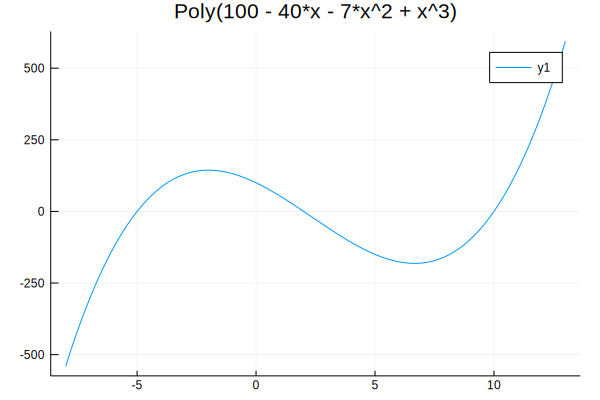

In [4]:
plot(p)

We can evaluate the polynomial at any point along the x axis:

In [5]:
p(1)

54

As you'd expect the polynomial evaluates to zero at the roots:

In [6]:
p(2)

0

We will need to access the coefficient values directly:

In [7]:
coeffs(p)

4-element Array{Int64,1}:
 100
 -40
  -7
   1

Now that we've gotten the coefficients from our polynomials we can encrypt them using the [Paillier.jl](https://github.com/hardbyte/Paillier.jl) package.

In [8]:
using Paillier

First we'll generate a new public/private keypair. In the private set intersection protocol only the client will have access to the private key.

In [9]:
pub, priv = generate_paillier_keypair(512);

Let's briefly investigate these homomorphic properties. We multiply an encrypted number by 2 (a plaintext scalar), then add two encrypted numbers together:

In [10]:
decrypt(priv, 2 * encrypt(pub, 10) + encrypt(pub, 5))

25

Our inputs might not be integers, so we define an encoding from a Julia datatype for the public key. In this case we will map `Float64` numbers to `BigInt`.

In [103]:
client_input_set = Set([0.0, 1.0, 0.456, 32, 72, 0.5])
encoding = Encoding(Float64, pub)
exponent = -10
encoded_input_set = [encode(x, encoding, exponent).value for x in client_input_set]

6-element Array{BigInt,1}:
              0
   501377302266
 35184372088832
   549755813888
 79164837199872
  1099511627776

These _encoded inputs_ will be used as our polynomial roots. Remember this constructor assumes the form: `(x - a1)(x - a2)...`

In [104]:
p = poly(encoded_input_set)

Poly(-844143837906021145209112739475215781925673137827591153235525632*x + 4021538057358975815249859704397123842414322206638080*x^2 - 6154309669748639409479151141905420517376*x^3 + 3032720982491832368481959936*x^4 - 116499854032634*x^5 + x^6)

In [105]:
polynomialcoeffs = coeffs(p)

7-element Array{BigInt,1}:
                                                                0
 -844143837906021145209112739475215781925673137827591153235525632
             4021538057358975815249859704397123842414322206638080
                        -6154309669748639409479151141905420517376
                                     3032720982491832368481959936
                                                 -116499854032634
                                                                1

The polynomial coefficients now have negative values, **which can't be encrypted** (without encoding).

In [106]:
encrypt(pub, polynomialcoeffs[2])

DomainError: DomainError with Can't encrypt negative integers without encoding:


To get around this we map the signed coefficients onto the $Z_n$ ring. $n$ is a very large integer that is part of the Paillier public key.

Broadcast the `mod` operator across the array:

In [107]:
polynomialcoeffs_zn = mod.(polynomialcoeffs, pub.n)

7-element Array{BigInt,1}:
                                                                                                                                                           0
 11402890060250396227734142451663363280469024798656361203129159238121750968913453864197187992587016047902313569346109629106876300180695299357538310479138325
                                                                                                        4021538057358975815249859704397123842414322206638080
 11402890060250396227734142451663363280469024798656361203129159238121750968913453864197187993431159885808334714555216214272422333466958958033987558294146581
                                                                                                                                3032720982491832368481959936
 11402890060250396227734142451663363280469024798656361203129159238121750968913453864197187993431159885808334714555222368582092082106368437185012963860631323
                               

These coefficients are positive but also in some cases very large. Note when we encoded the client input set we purposely mapped to `BigInt` to avoid wrapping around that `Int64` numbers would exhibit. 

Now we can use Paillier to encrypt the polynomial coefficients:

In [108]:
encrypted_polynomial = [encrypt(pub, coeff) for coeff in polynomialcoeffs_zn];

These encrypted coefficients, the encoding, and the public key are now shared to the _server_ party with their own input set $B$. The server follows the same process to encode their input set:

In [109]:
server_set = Set([0.0, 123, 32.0, 45.0, 72, 0.5])
encoded_server_set = [encode(x, encoding, exponent).value for x in server_set]

6-element Array{BigInt,1}:
               0
  35184372088832
 135239930216448
    549755813888
  79164837199872
  49478023249920

Now the server evaluates the encrypted polynomial at each of their inputs. This is the naive way to evaluate the polynomial:

In [110]:
function evaluate_enc_p(x, encrypted_polynomial)
    encres = encrypt(pub, 0)
    for power in 0:length(encrypted_polynomial)-1
        a = encrypted_polynomial[power+1]
        encres += a * x^power
    end
    return encres
end

serverresults = []

for input in encoded_server_set
    enc_p_y = evaluate_enc_p(input, encrypted_polynomial)

    enc_y = encrypt(pub, input)

    # Multiplying by this r should take the result outside of possible set values:
    r = Main.Paillier.n_bit_random_number(32)

    push!(serverresults, r * enc_p_y + enc_y)
end

Now the results of evaluating an encrypted polynomial are still encrypted and the server doesn't have the private key. The final step in this private set intersection protocol is carried out by the client. The server sends over `serverresults` and the client can compute the intersection.

The client decrypts each result from the server, compares to the clients own (encoded) input set, and if there was a match we know that the decoded input is shared.

In [111]:
function get_intersection(encoded_input_set, enc, privatekey, encoding)
    intersection::Set{encoding.datatype} = Set()
    for encval in enc
            decrypted = decrypt(privatekey, encval)
            
            if decrypted in encoded_input_set
                decoded = decode(decrypted, exponent, encoding)
                push!(intersection, decoded)
            end
    end
    intersection
end

get_intersection(encoded_input_set, serverresults, priv, encoding)

Set([0.0, 32.0, 0.5, 72.0])

Okay the client has identified which inputs intersected with the servers. 

This is just the first pass - the paper points out a few things to improve on such as evaluating the encrypted polynomial using Horner's rule. I don't think it is worth adding them to the blog post though, but if you're interested take a look through the final code in [examples/private_set_intersection.jl](https://github.com/hardbyte/Paillier.jl/blob/master/examples/private_set_intersection.jl).

## References

- [1] Freedman M.J., Nissim K., Pinkas B. (2004) Efficient Private Matching and Set Intersection. In: Cachin C., Camenisch J.L. (eds) Advances in Cryptology - EUROCRYPT 2004. EUROCRYPT 2004. Lecture Notes in Computer Science, vol 3027. Springer, Berlin, Heidelberg [[pdf](https://link.springer.com/content/pdf/10.1007/978-3-540-24676-3_1.pdf)]
